In [4]:
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
from glob import glob
import numpy as np
import pickle

%matplotlib inline

In [5]:
# Programme structure
#---------------------
# 1. Import binary masks and images.
# 2. Get indices of pixels corresponding to cracks.
# 3. Define a KxK kernel.
# 4. Extract KxK windows of pixels centered on the crack pixels that satisfy:
#          4 * # Crack px. > # Nocrack px.
# 5. The number of 'crack' windows is m.
# 6. Sample m nocrack windows: take the range 
#              [0 + r, image_size - r, m/52]
#    where r is a random integer less than 20. Test the indices gathered.
#    If a window fails, increment one of the indices until it succeeds (captures 'edge' cases).
# 7. Assign the windows unique IDs and one-hot encoded labels.
# 8. Split the data into training, testing, and validation sets.
# 9. Pickle these sets to the EBS storage (mount it first!).

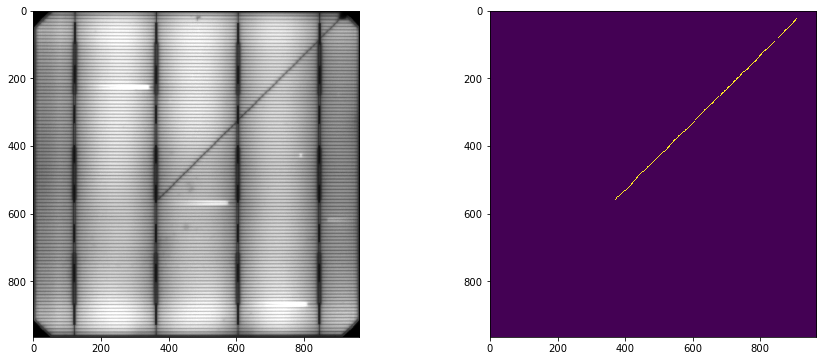

In [6]:
# 1. Import binary masks and images.
images = np.array([imread(fp).astype(np.uint8) for fp in glob('../data/resized-images/*.png')])
masks  = np.array([imread(fp)//255 for fp in glob('../data/masked-images/*.png')])

f, axs = plt.subplots(1, 2, figsize = (15, 6))
axs[0].imshow(images[24], cmap = 'gray'); axs[1].imshow(masks[24]);

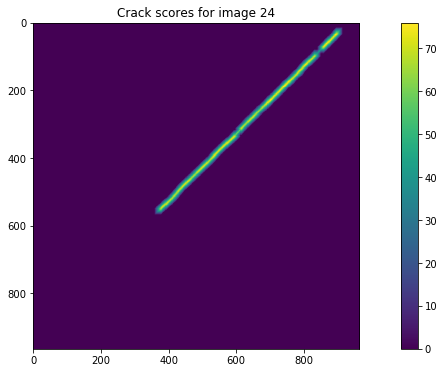

In [7]:
# 3. Define a KxK kernel. We use a 20 x 20px one based on measurements of the crack dimensions (See the report).
K      = 20
kernel = np.ones([1, K, K])

# 4. Convolve the kernel with each image to obtain crack scores for each 10x10 patch in an image.
crack_scores = convolve(masks, kernel)

# Plot them
plt.figure(figsize = (15, 6))
plt.imshow(crack_scores[24]); plt.title('Crack scores for image 24'); plt.colorbar();

In [8]:
# 5. Extract all windows with crack scores greater than a threshold (we use 20).
score_threshold      = 0.2 * K * K
n_samples            = 12000
patch_data           = {'cracks':np.zeros([n_samples, K, K], np.uint8),
                        'nocracks':np.zeros([n_samples, K, K], np.uint8)}

crack_ix  = np.array(np.nonzero(crack_scores > score_threshold)).T
rnd_ix    = np.random.choice(range(crack_ix.shape[0]), n_samples, replace = False)
img       = images[crack_ix[rnd_ix[0]][0]]
pimg      = np.pad(img, pad_width = [[K, K], [K, K]],
                        mode = 'constant', constant_values = 0)

for j, px_ix in enumerate(crack_ix[rnd_ix]):
    if np.any(img != images[px_ix[0]]):
        img = images[px_ix[0]]
        pimg = np.pad(img, pad_width = [[K, K], [K, K]],
                             mode = 'constant', constant_values = 0)
    patch_data['cracks'][j, :, :] = pimg[px_ix[1] + K//2 : px_ix[1] + (3 * K // 2),
                                         px_ix[2] + K//2 : px_ix[2] + (3 * K // 2)]

In [9]:
# 6. Extract an equally sized sample of windows with crack scores less than the threshold.
nocrack_ix  = np.array(np.nonzero(crack_scores < score_threshold)).T
rnd_ix      = np.random.choice(range(nocrack_ix.shape[0]), n_samples, replace = False)

for j, px_ix in enumerate(nocrack_ix[rnd_ix]):
    if np.any(img != images[px_ix[0]]):
        img = images[px_ix[0]]
        pimg = np.pad(img, pad_width = [[K, K], [K, K]],
                             mode = 'constant', constant_values = 0)
    patch_data['nocracks'][j, :, :] = pimg[px_ix[1] + K//2 : px_ix[1] + (3 * K // 2),
                                              px_ix[2] + K//2 : px_ix[2] + (3 * K // 2)]

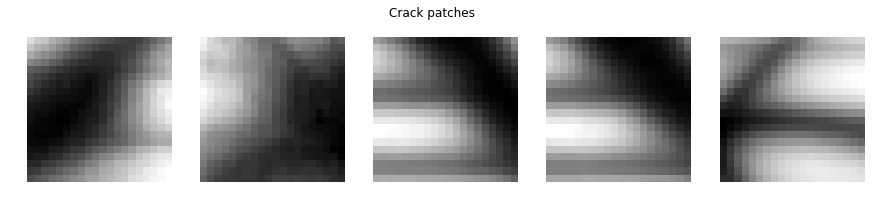

In [10]:
f, axs = plt.subplots(1, 5, figsize = (15, 3))
for ax in axs:
    ax.imshow(patch_data['cracks'][np.random.randint(patch_data['cracks'].shape[0])],
              cmap = 'gray'); ax.axis('off');
f.suptitle('Crack patches');

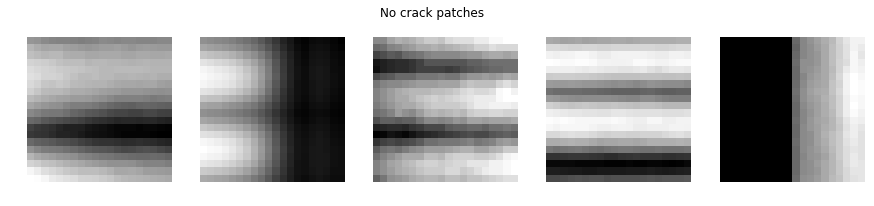

In [11]:
f, axs = plt.subplots(1, 5, figsize = (15, 3))
for ax in axs:
    ax.imshow(patch_data['nocracks'][np.random.randint(patch_data['nocracks'].shape[0])],
              cmap = 'gray'); ax.axis('off');
f.suptitle('No crack patches');

In [12]:
def train_test_split(images, labels, train_frac=0.8):
    mask           = np.array([False]*labels.shape[0])
    rnd_ix         = np.random.choice(range(mask.shape[0]),
                                      int(train_frac * labels.shape[0]), 
                                      replace = False)
    mask[rnd_ix]   = True
    train_images   = images[mask, :, :]
    train_labels   = labels[mask, :]
    test_images    = images[np.logical_not(mask), :, :]
    test_labels    = labels[np.logical_not(mask), :]
    return train_images, test_images, train_labels, test_labels

In [13]:
# 7. Create one-hot encoded labels and split the data into training, testing, and validation sets.

data = np.concatenate([patch_data['cracks'], patch_data['nocracks']], 0)
data = data.astype(np.float32)
data = data - np.mean(data, axis = 0)
data = data / np.std(data, axis = 0)


image_labels = np.zeros([n_samples * 2, 2], float)
image_labels[n_samples:, 0] = 1.
image_labels[:n_samples, 1] = 1.

train_dataset, test_dataset, train_labels, test_labels = train_test_split(data, image_labels)
test_dataset, valid_dataset, test_labels, valid_labels = train_test_split(test_dataset, test_labels, 0.5)

In [19]:
# 8. Pickle the datasets to the local disk.

def pickle_data(data, labels, name):
    pickle.dump(data, open('../data/' + name + '_dataset.p', 'wb'))
    pickle.dump(labels, open('../data/' + name + '_labels.p', 'wb'))
    
pickle_data(train_dataset, train_labels, 'train')
pickle_data(test_dataset, test_labels, 'test')
pickle_data(valid_dataset, valid_labels, 'valid')
print('Data pickled successfully.')

Data pickled successfully.
